In [1]:
pip install jiwer

     -------------------------------------- 96.6/96.6 kB 690.8 kB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [4]:
data_url= "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path=keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

In [5]:
wavs_path= data_path +"/wavs/"
metadata_path = data_path +"/metadata.csv"

In [6]:
#reading metadata file and parsing it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [7]:
 metadata_df.head()

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [9]:
metadata_df

,file_name,normalized_transcription
0,LJ039-0006,Another alleged threat by Oswald against a pub...
1,LJ050-0167,to develop coordinated and mutually compatible...
2,LJ048-0153,while on the overpass overlooking the assassin...
3,LJ012-0191,of atrocious murders perpetrated in Edinburgh ...
4,LJ012-0158,Before his confinement he had been a sleek rou...
...,...,...
13095,LJ011-0066,The concourse in front of Newgate was enormous...
13096,LJ025-0021,yet none of these movements justify the ascrip...
13097,LJ031-0161,Secret Service agents working with police clea...
13098,LJ002-0218,A committee of the House of Commons investigat...


In [8]:
metadata_df.columns =["file_name","Transcription","normalized_transcription"]
metadata_df=metadata_df[["file_name","normalized_transcription"]]
metadata_df=metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head()

,file_name,normalized_transcription
0,LJ039-0006,Another alleged threat by Oswald against a pub...
1,LJ050-0167,to develop coordinated and mutually compatible...
2,LJ048-0153,while on the overpass overlooking the assassin...
3,LJ012-0191,of atrocious murders perpetrated in Edinburgh ...
4,LJ012-0158,Before his confinement he had been a sleek rou...


In [14]:
#split
split=int(len(metadata_df)*0.005)
df_train=metadata_df[:split]
df_val=metadata_df[split:100]

print(f"Size of training set:{len(df_train)}")
print(f"Size of value set:{len(df_val)}")

Size of training set:65
Size of value set:35


#We will prepare vocab now


In [10]:
characters=[x for x in "abcdefghijklmnopqrstuvwxyz'?!"]
char_to_num=keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char =keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is :{char_to_num.get_vocabulary()}"
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is :['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!'](size=30)


In [11]:
frame_length=256
frame_step=160
fft_length=384


def  encode_single_sample(wav_file, label):
    
    file=tf.io.read_file(wavs_path +wav_file+".wav")
    
    audio, _ =tf.audio.decode_wav(file)
    
    audio=tf.squeeze(audio, axis=-1)
    
    audio= tf.cast(audio,tf.float32)
    
    spectogram=tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    
    spectogram=tf.abs(spectogram)
    
    spectogram=tf.math.pow(spectogram,0.5)
    
    means=tf.math.reduce_mean(spectogram,1, keepdims=True)
    
    stddevs=tf.math.reduce_std(spectogram,1, keepdims=True)
    
    spectogram=(spectogram-means)/(stddevs+1e-10)
    
    label=tf.strings.lower(label)
    
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    
    label = char_to_num(label)
    
    return spectogram, label
    
    

In [15]:
batch_size=13

train_dataset=tf.data.Dataset.from_tensor_slices(
              (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset=(
         train_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE)
         .padded_batch(batch_size)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset=tf.data.Dataset.from_tensor_slices(
   (list(df_val["file_name"]),list(df_val["normalized_transcription"]))
)


validation_dataset=(
           validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
           .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

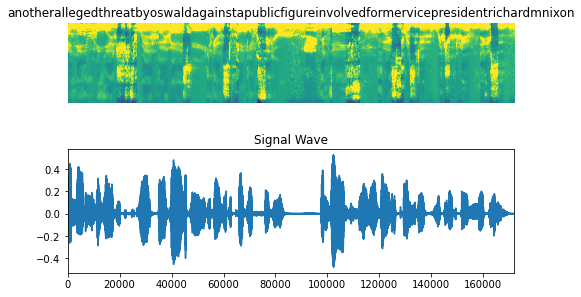

In [16]:
fig=plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    
    spectogram = batch[0][0].numpy()
    spectogram=np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    label=batch[1][0]
    
    label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax=plt.subplot(2,1,1)
    ax.imshow(spectogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    
    file=tf.io.read_file(wavs_path +list(df_train["file_name"])[0] + ".wav")
    audio, _ =tf.audio.decode_wav(file)
    audio=audio.numpy()
    ax=plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio),rate =16000))
    plt.show()
    

In [14]:
def CTCLoss(y_true, y_pred):
    batch_len=tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length=tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length=tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length=input_length * tf.ones(shape=(batch_len,1),dtype="int64")
    label_length=label_length * tf.ones(shape=(batch_len,1),dtype="int64")
    
    loss=keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [15]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    
    input_spectogram=layers.Input((None, input_dim), name="input")
    
    x=layers.Reshape((-1, input_dim, 1),name="expand_dim")(input_spectogram)
    #Layer1
    x=layers.Conv2D(
       filters=32,
    kernel_size=[11,41],
    strides=[2,2],
    padding="same",
    use_bias=False,
    name="conv_1",
    )(x)
    
    x=layers.BatchNormalization(name="conv_1_bn")(x)
    x=layers.ReLU(name="conv_1_relu")(x)
    
    #Layer2
    x=layers.Conv2D(
       filters=32,
    kernel_size=[11,21],
    strides=[1,2],
    padding="same",
    use_bias=False,
    name="conv_2",
    )(x)
    
    x=layers.BatchNormalization(name="conv_2_bn")(x)
    x=layers.ReLU(name="conv_2_relu")(x)
        
    x=layers.Reshape((-1, x.shape[-2]* x.shape[-1]))(x)
    
    for i in range(1, rnn_layers+1):
        recurrent= layers.GRU(
               units=rnn_units,
               activation="tanh",
               recurrent_activation="sigmoid",
               use_bias=True,
               return_sequences=True,
               reset_after=True,
               name=f"gru_{i}",
        )
        x=layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i<rnn_layers:
            x=layers.Dropout(rate=0.55)(x)
            
    #DenseLayer
    x=layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x=layers.ReLU(name="dense_1_relu")(x)
    x=layers.Dropout(rate=0.5)(x)
    
    
    output=layers.Dense(units=output_dim+1, activation="softmax")(x)
    
    model=keras.Model(input_spectogram, output, name="dl_eNGINE")
    
    opt=keras.optimizers.Adam(learning_rate=1e-2)
    
    model.compile(optimizer=opt, loss=CTCLoss)
    
    return model
    


In [16]:
model =build_model(
        input_dim=fft_length//2+1,
        output_dim=char_to_num.vocabulary_size(),
        rnn_units=256,
        )
 
model.summary(line_length=110)

Model: "dl_eNGINE"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                        

In [27]:
def decode_batch_predictions(pred):
    input_len=np.ones(pred.shape[0])*pred.shape[1]
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    output_text=[]
    for result in results:
        result=tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


class CallbackEval(keras.callbacks.Callback):
    
    
    def __int__(self , dataset):
        super().__init__()
        self.dataset=dataset
        
    def on_epoch_end(self, epoch:int, logs=None):
        predictions=[]
        targets=[]
        for batch in self.dataset:
            X, y=batch
            batch_predictions=model.predict(X)
            batch_predictions=decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label=(
                  tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)
        wer_score=wer(targets,predictions)
        
        print("-" *100)
        print(f"Word Error RAte:{wer_score:.4f}")
        print("-" *100)
        for i in np.random.randint(0, len(predictions),2):
            print(f"target      :{targets[i]}")
            print(f"prediction      :{predictions[i]}")
            print("-"*100)

In [18]:
epochs=1


history =model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,)

5/5 [==============================] - 198s 40s/step - loss: 1869.8849 - val_loss: 2740.0461


In [29]:
predictions=[]
targets=[]
for  batch in validation_dataset:
    X, y= batch
    batch_predictions=model.predict(X)
    batch_predictions=decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    
    for label in y:
        label= tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score=wer(targets, predictions)
print("-" *100)
print(f"Word Error Rate:{wer_score:.4f}")
print("-" *100)

for i in np.random.randint(0, len(predictions),5):
    print(f"Target:{targets[i]}")
    print(f"Predictions:{predictions[i]}")
    print("-" *100)

1/1 [==============================] - 2s 2s/step
----------------------------------------------------------------------------------------------------
Word Error Rate:1.0000
----------------------------------------------------------------------------------------------------
Target:noonewhofelleverroseagain
Predictions:te
----------------------------------------------------------------------------------------------------
Target:norwerethemisdemeanantsandbailprisonersanylongerseparatedfromthosewhosecrimeswereofamoreseriouscharacter
Predictions:te
----------------------------------------------------------------------------------------------------
Target:itistheconclusionofthecommissionthatevenintheabsenceofsecretservicecriteria
Predictions:te
----------------------------------------------------------------------------------------------------
Target:cunninghamdeclaredthatthisweaponfiredthefourcartridgestotheexclusionofallotherweapons
Predictions:te
-----------------------------------------